In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

import discretize
from discretize import TensorMesh

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver
    
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

## Load Data and Plot

In [26]:
# path to the directory containing our data
dir_path = "./3d_simulation_data/"
data_filename = dir_path + "em3dfm_1d_data.txt"

In [10]:
location_index = 9

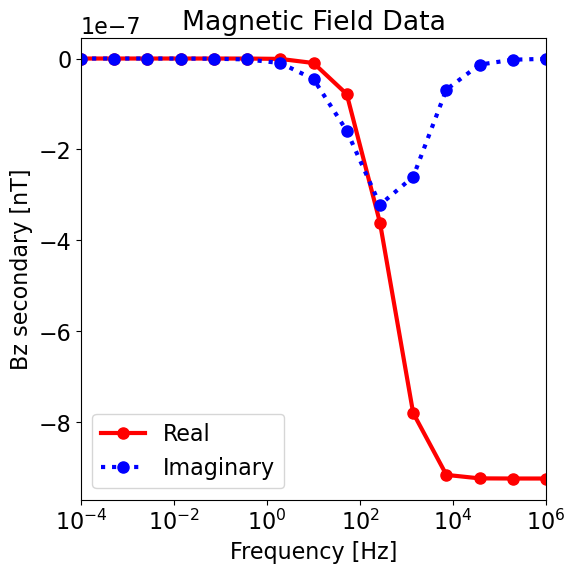

In [11]:
dobs = np.loadtxt(str(data_filename), skiprows=1)
ntx = int((dobs.shape[1]-1)/2)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs_real = dobs[:, 1::2].T
dobs_imag = dobs[:, 2::2].T

# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*dobs_real[location_index, :], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*dobs_imag[location_index, :], "b:o", lw=3)
ax.set_xlim((np.min(frequencies), np.max(frequencies)))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Bz secondary [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

## Defining the Survey

In [14]:
x_positions = np.arange(0, 10000, 500)

In [17]:
frequencies = np.logspace(-2, 8, 15)
moment = 1

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid([x_positions[location_index]], [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid([x_positions[location_index]+ 10], [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

dpreds = []

# Each unique location and frequency defines a new transmitter
for ii in range(ntx):
    source_list = [] 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = moment
            )
        )

# create the survey and problem objects for running the forward simulation
survey = fdem.Survey(source_list)


## Assign Uncertainties

In [18]:
# Recover the vector data structure
bz_real = dobs_real[location_index]
bz_imag = dobs_imag[location_index]

dobs_recovered = np.empty(bz_real.size + bz_imag.size, dtype=bz_real.dtype)
dobs_recovered[0::2] = bz_real
dobs_recovered[1::2] = bz_imag

In [19]:
uncertainties = 0.01 * np.abs(dobs_recovered) * np.ones(np.shape(dobs_recovered))

In [20]:
data_object = data.Data(survey, dobs=dobs_recovered, noise_floor=uncertainties)

## Weighted Least-Squares Inversion

In [21]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 0.5 m
MAXIMUM SKIN DEPTH: 50000.0 m


In [22]:
depth_min = 10  # top layer thickness
depth_max = 6000.0  # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

In [23]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  45


## Model and Mapping to Layer Conductivities

In [24]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

## Define a Refernce Model and the Mapping

In [25]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

In [80]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
)

## Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [81]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [83]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 45 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     45     -7,128.81         -0.00     10.00    602.40    1.10




In [84]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)

In [85]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

## Define Inversion Directives

In [86]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [87]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit]

In [88]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_resistivity_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.46e+03  6.48e+06  0.00e+00  6.48e+06    5.12e+06      0              
   1  4.46e+03  2.90e+06  3.43e+02  4.43e+06    1.24e+06      0              
   2  4.46e+03  3.03e+06  2.55e+02  4.17e+06    4.28e+05      0              
   3  2.23e+03  3.00e+06  2.56e+02  3.57e+06    1.16e+06      0              
   4  2.23e+03  1.95e+06  6.29e+02  3.35e+06    3.62e+05      0              
   5  2.23e+03  2.24e+06  4.89e+02  3.33e+06    1.82e+05      0              
   6  1.12e+03  2.11e+06  5.45e+0

In [89]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

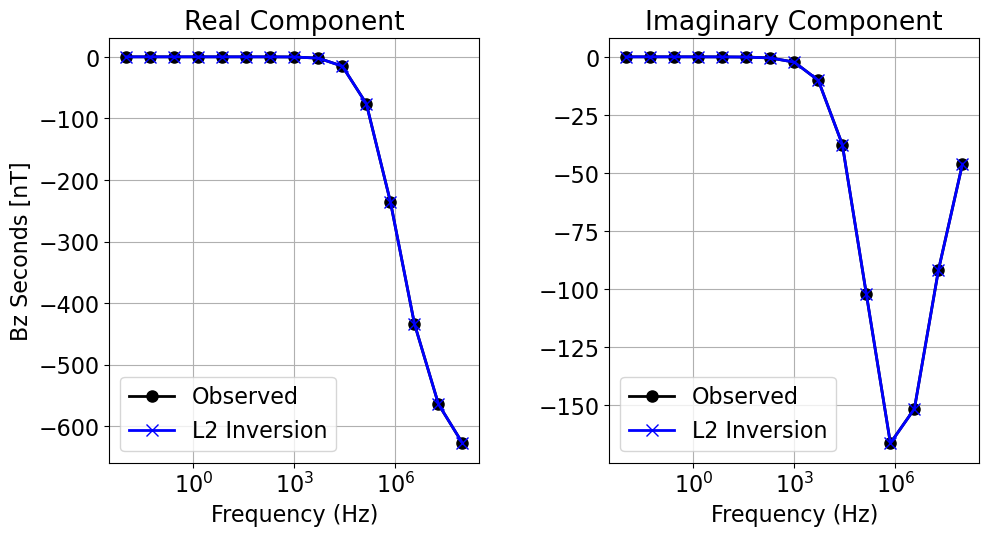

In [90]:
fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].semilogx(frequencies, (10**9) *(dobs_recovered[ii::2]), "k-o", lw=2)
    ax[ii].semilogx(frequencies, (10**9) *(dpred_L2[ii::2]), "b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("Bz Seconds [nT]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

In [93]:
# Define layer thicknesses (m)
true_layers = np.array([1000.0, 1500.0])

# Define layer conductivities (S/m)
true_resistivities = np.r_[1000, 10, 100]

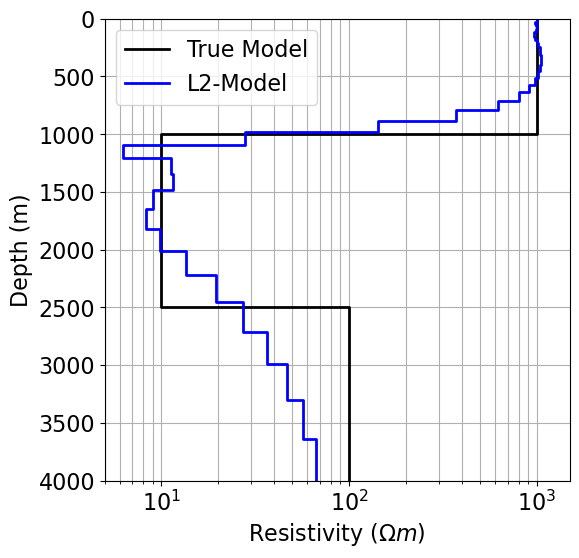

In [94]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_ylim([4000, 0])
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()

In [46]:
def recover_model(location_index, x_position):
    # path to the directory containing our data
    dir_path = "./3d_simulation_data/"
    data_filename = dir_path + "em3dfm_1d_data.txt"

    dobs = np.loadtxt(str(data_filename), skiprows=1)
    dobs_real = dobs[:, 1::2].T
    dobs_imag = dobs[:, 2::2].T
    bz_real = dobs_real[location_index]
    bz_imag = dobs_imag[location_index]

    dobs_recovered = np.empty(bz_real.size + bz_imag.size, dtype=bz_real.dtype)
    dobs_recovered[0::2] = bz_real
    dobs_recovered[1::2] = bz_imag

    # Define Survey
    frequencies = dobs[:, 0]

    source_location = np.array([x_position, 0.0, 30.0])
    receiver_location = np.array([x_position + 10, 0.0, 30.0])

    # Each unique location and frequency defines a new transmitter
    receiver_list = []
    receiver_list.append(
        fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_location,
            orientation='z',
            component="real",
        )
    )
    receiver_list.append(
        fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_location,
            orientation='z',
            component="imag",
        )
    )

    source_list = []
    for freq in frequencies:
        source_list.append(
            fdem.sources.MagDipole(
                receiver_list=receiver_list,
                frequency=freq,
                location=source_location,
                orientation="z",
                moment=1.0,
            )
        )
    survey = fdem.survey.Survey(source_list)

    uncertainties = 0.01 * np.abs(dobs_recovered) * np.ones(np.shape(dobs_recovered))
    data_object = data.Data(survey, dobs=dobs_recovered, noise_floor=uncertainties)

    # estimated host conductivity (S/m)
    estimated_resistivity = 100

    depth_min = 10  # top layer thickness
    depth_max = 6000.0  # depth to lowest layer
    geometric_factor = 1.1  # rate of thickness increase

    # Increase subsequent layer thicknesses by the geometric factors until
    # it reaches the maximum layer depth.
    layer_thicknesses = [depth_min]
    while np.sum(layer_thicknesses) < depth_max:
        layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

    n_layers = len(layer_thicknesses) + 1  # Number of layers

    log_resistivity_map = maps.ExpMap(nP=n_layers)

    # Starting model is log-conductivity values (S/m)
    starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

    # Reference model is also log-resistivity values (S/m)
    reference_resistivity_model = starting_resistivity_model.copy()

    simulation_L2 = fdem.Simulation1DLayered(
        survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
    )

    dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

    # Define 1D cell widths
    h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
    h = np.flipud(h)

    # Create regularization mesh
    regularization_mesh = TensorMesh([h], "N")

    reg_L2 = regularization.WeightedLeastSquares(
        regularization_mesh,
        length_scale_x=10.0,
        reference_model=reference_resistivity_model,
        reference_model_in_smooth=False,
    )

    opt_L2 = optimization.InexactGaussNewton(
        maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
    )

    inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

    update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
    beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
    target_misfit = directives.TargetMisfit(chifact=1.0)

    directives_list_L2 = [update_jacobi, 
                        starting_beta, 
                        beta_schedule, 
                        target_misfit]

    # Here we combine the inverse problem and the set of directives
    inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

    # Run the inversion
    recovered_model_L2 = inv_L2.run(starting_resistivity_model)

    return recovered_model_L2

In [120]:
x_positions = np.arange(0, 10000, 500)
cell_width = 500

<Axes: xlabel='x1', ylabel='x2'>

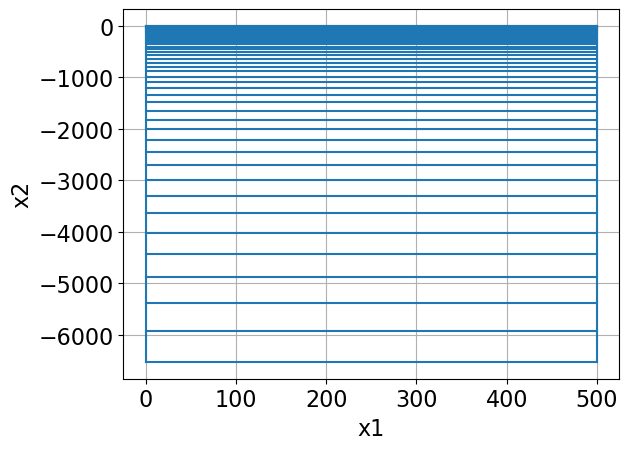

In [121]:
# Define cell widths in x-direction
hx = [cell_width]

# Define cell heights in z-direction
hz = np.array(layer_thicknesses[::-1])

# Create TensorMesh
plotting_mesh = discretize.TensorMesh([hx, hz])
plotting_mesh.x0 = [0, -plotting_mesh.h[1].sum()]
plotting_mesh.plot_grid()

In [122]:
models = []
for i, x in enumerate(x_positions):
    model_recovered = recover_model(i,x)
    model_recovered = (model_recovered[::-1])[1:]
    models.append(model_recovered)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.56e+03  5.17e+06  0.00e+00  5.17e+06    4.32e+06      0              
   1  3.56e+03  2.23e+06  3.49e+02  3.47e+06    9.91e+05      0              
   2  3.56e+03  2.38e+06  2.53e+02  3.28e+06    3.54e+05      0              
   3  1.78e+03  2.34e+06  2.57e+02  2.80e+06    9.46e+05      0              
   4  1.78e+03  1.51e+06  6.28e+02  2.63e+06    3.06e+05      0              
   5  1.78e+03  1.75e+06  4.86e+02  2.61e+06    1.68e+05      0              
   6  8.90e+02  1.63e+06  5.46e+0

(-4000.0, 0.0)

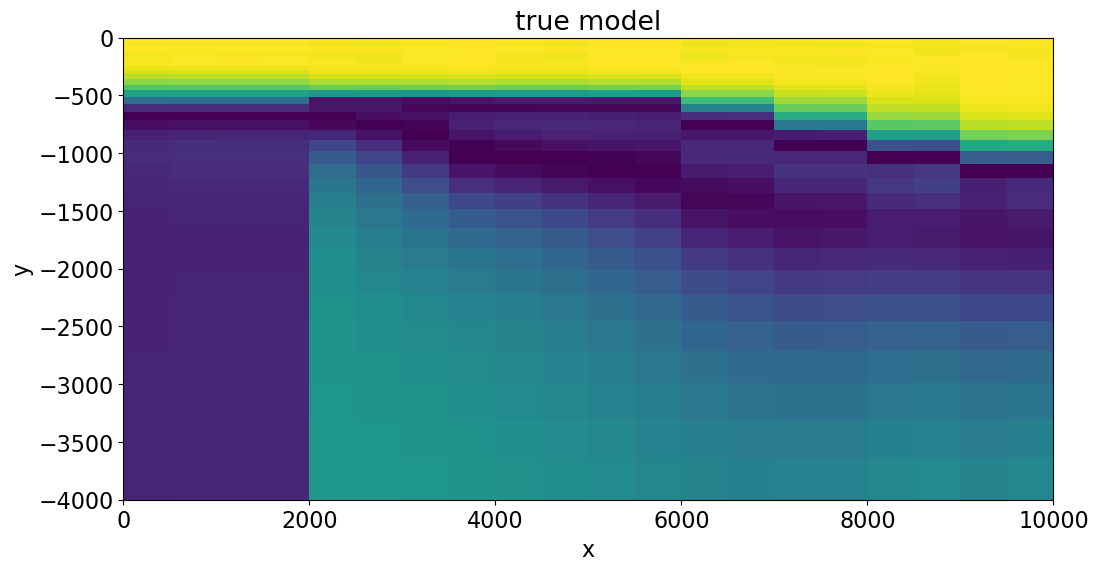

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

for i, x in enumerate(x_positions):
    plotting_mesh.x0 = [x_positions[i], -plotting_mesh.h[1].sum()]
    plotting_mesh.plot_image(models[i], ax=ax)[0]
    
ax.set_title("true model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])

In [ ]:
# fdem.Simulation3DMagneticFluxDensity(
#         mesh, survey=survey, rhoMap=mapping_1d, solver=Solver
# )

# dpreds.append(prob.dpred(z_values_model))